## Planet: Understanding the Amazon from Space 🌳🛰️
#### Use satellite data to track the human footprint in the Amazon rainforest

#### Goal:
to tag satellite data chips with information on atmospheric conditions and land use/land cover by performing image multioutput classification

#### Data:
- 3-band, 8-bit satellite data chips of size 256x256 pixels, being parts of Planet's '*visual product*' created based on imagery from ISS and Flock 2 satellite, characterized by GSD of app. 3.7 m, saved in *.jpg* format [1]
- training data annotation *.csv* file [1]

#### Study area and time:
data collected:
- over '*Amazon basin which includes Brazil, Peru, Uruguay, Colombia, Venezuela, Guyana, Bolivia, and Ecuador*' [1]
- '*between January 1, 2016 and February 1, 2017*' [1]

#### Processing steps:
part 1: EDA and data pre-processing
1. Downloading the source data using Kaggle API and unzipping it
2. Analyzing the training annotation file
3. Analyzing the training images

part 2: Baseline model - next notebook <br>
part 3: PyTorch CNN models - next notebook

#### Sources: 
[1] Kaggle competiton *Planet: Understanding the Amazon from Space*, section Data: https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/data <br> 
[2] Kaggle API usage advices: https://stackoverflow.com/questions/55934733/documentation-for-kaggle-api-within-python <br>
[3] TorrentP Python library's GitHub page: https://github.com/iw4p/torrentp <br>
[4] Kaggle competiton *Planet: Understanding the Amazon from Space*, section Discussion: https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/discussion <br> 
[5] Kaggle dataset *planets_dataset*: https://www.kaggle.com/datasets/nikitarom/planets-dataset <br>
[6] Introductory Jupyter Notebook presenting information on the source data; prepared by Planet: https://github.com/planetlabs/planet-amazon-deforestation/blob/master/planet_chip_examples.ipynb <br>
[7] multiprocessing Python library's GitHub page: https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing <br>
[8] Jason Brownlee's SuperFastPython blog post: https://superfastpython.com/numpy-multithreaded-parallelism/ <br>
[9] dask Python library's GitHub page: https://docs.dask.org/en/stable/ <br>
[10] segment-anything Python library's GitHub page: https://github.com/facebookresearch/segment-anything

### Step 0: Importing packages

In [1]:
import glob
import os
import time
import warnings
import zipfile
warnings.filterwarnings("ignore")

In [2]:
import earthpy.plot as ep
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pysptools.noise
import seaborn as sns
import seedir as sd
from sklearn.manifold import TSNE
from torrentp import TorrentDownloader

### Step 1: Downloading the source data using Kaggle API and unzipping it

As the first step, I needed to create the Kaggle account and download the Kaggle API token following instructions in [2]. Then, I was ready to download the source data using the API: 

In [3]:
api = KaggleApi()

In [4]:
api.authenticate()

In [5]:
competition_name = 'planet-understanding-the-amazon-from-space'

In [ ]:
api.competition_download_files(competition_name)

In [ ]:
with zipfile.ZipFile(competition_name + '.zip', 'r') as zip_ref:
    zip_ref.extractall(competition_name)

In [6]:
sd.seedir(competition_name, itemlimit=5)

planet-understanding-the-amazon-from-space/
├─Kaggle-planet-train-tif.torrent
├─Kaggle-planet-test-tif.torrent
├─test_v2_file_mapping.csv/
│ ├─test_v2_file_mapping.csv
│ └─.ipynb_checkpoints/
│   └─test_v2_file_mapping-checkpoint.csv
├─sample_submission_v2.csv/
│ ├─sample_submission_v2.csv
│ └─.ipynb_checkpoints/
│   └─sample_submission_v2-checkpoint.csv
└─train_v2.csv/
  ├─.ipynb_checkpoints/
  │ └─train_v2-checkpoint.csv
  └─train_v2.csv


The folder contains an annotation file for training images ('*train_v2.csv*'), a sample submission file ('*sample_submission_v2.csv*') and a mapping of test image names between v1 and v2 ('*test_v2_file_mapping.csv*'). The folder also includes metadata of train and test images stored as *.torrent* files. I tried to download the image files using *torrentp* package:

In [7]:
# following [3] 
torrent_test_file = TorrentDownloader(competition_name + '/Kaggle-planet-test-tif.torrent', '.')

In [8]:
torrent_train_file = TorrentDownloader(competition_name + '/Kaggle-planet-train-tif.torrent', '.')

In [ ]:
torrent_test_file.start_download()

In [ ]:
torrent_test_file.start_download()

The *.torrent* files for *.tiff* images must be inactive, as the download process remains 0% for both train and test. Following the advice posted in the challenge's 'Discussion' section [4], I downloaded the *.jpg* data from a non-official dataset [5]:

In [9]:
dataset_name = 'nikitarom/planets-dataset'

In [ ]:
api.dataset_download_files(dataset_name)

In [ ]:
with zipfile.ZipFile('planets-dataset' + '.zip', 'r') as zip_ref:
    zip_ref.extractall('planets-dataset')

In [10]:
sd.seedir('planets-dataset', itemlimit=5)

planets-dataset/
├─planet/
│ └─planet/
│   ├─train_classes.csv
│   ├─test-jpg/
│   │ ├─test_36099.jpg
│   │ ├─test_27503.jpg
│   │ ├─test_15453.jpg
│   │ ├─test_20695.jpg
│   │ └─test_5439.jpg
│   ├─sample_submission.csv
│   ├─train-jpg/
│   │ ├─train_18754_flipped_denoised.jpg
│   │ ├─train_19921.jpg
│   │ ├─train_6794_flipped.jpg
│   │ ├─train_30819_flipped_denoised.jpg
│   │ └─train_29539_flipped.jpg
│   └─.ipynb_checkpoints/
│     ├─sample_submission-checkpoint.csv
│     └─train_classes-checkpoint.csv
└─test-jpg-additional/
  └─test-jpg-additional/
    ├─file_15828.jpg
    ├─file_17129.jpg
    ├─file_19569.jpg
    ├─file_6390.jpg
    └─file_2974.jpg


The new dataset contains similar annotation files, but now it also has train and test images in *.jpg* format.

### Step 2: Analyzing the training annotation file

<b> 2.1. Data preprocessing </b>

In [11]:
labels_df = pd.read_csv(competition_name + '/train_v2.csv/train_v2.csv')

In [12]:
labels_df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [13]:
labels_df.shape[0] # total number of training samples

40479

In [14]:
# Build list with unique labels (Planet's code [6])
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [15]:
print(*label_list, sep=', ')
print(len(label_list))

haze, primary, agriculture, clear, water, habitation, road, cultivation, slash_burn, cloudy, partly_cloudy, conventional_mine, bare_ground, artisinal_mine, blooming, selective_logging, blow_down
17


In [16]:
# Add onehot features for every label (Planet's code [6])
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

<b> 2.2. Exploratory Data Analysis (EDA) </b>

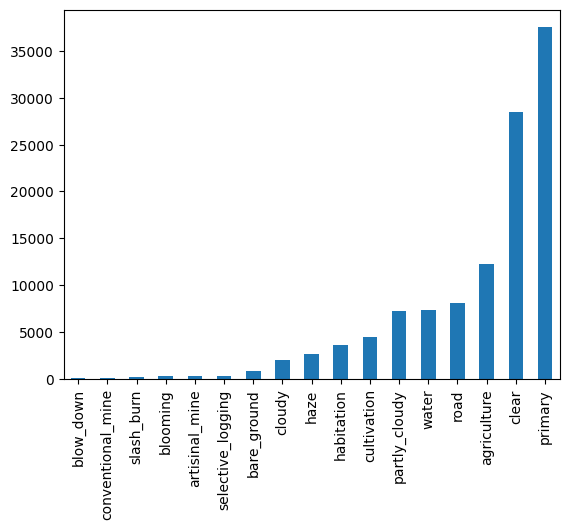

In [17]:
# Histogram of label instances (Planet's code [6])
labels_df[label_list].sum().sort_values().plot.bar();

There are 17 unique labels. From the competition's description [1] we can learn that they form three groups:
- '*atmospheric conditions*': clear, partly_cloudy, haze, cloudy
- '*common land cover/land use phenomena*': primary, agriculture, water, cultivation, habitation, road
- '*rare land cover/land use phenomena*': slash_burn, conventional_mine, bare_ground, artisinal_mine, blooming, selective_logging, blow_down

They are also interconnected:
- each chip should have only 1 tag characterizing the atmospheric conditions
- if the atmospheric conditions are '*cloudy*', than no other tag should be added (as nothing is visible in the fully cloudy passive remote sensing image)
- there are logical connections between tags e.g. if selective logging is present, '*primary*' (forest) and '*road*' should probably be around; if '*habitation*' is present, then it is highly probably we will find a '*road*' there

We can therefore conclude that: 
- implementing some measure of relationship between labels in the algorithm would be beneficial (e.g. https://arxiv.org/ftp/arxiv/papers/1604/1604.04573.pdf)
- the problem should be framed as either image multilabel classification (with 17 binary labels) or image multioutput classification (with 13 binary labels and 1 non-binary label for discerning between weather phenomena); for sure, it does not fit the definition of multioutput classification with three outputs because multiple land cover/land use phenomena can be present in one image

The bar plot shows that:
- most training chips are clear
- primary (forest), agriculture, road and water are the most frequently occuring land cover/land use phenomena

In [18]:
labels_df['num_labels'] = labels_df[label_list].sum(axis=1)

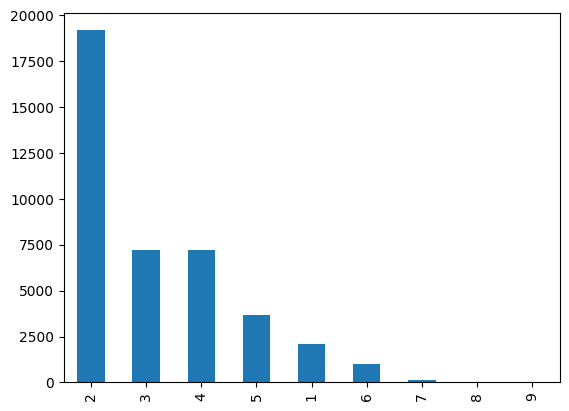

In [19]:
labels_df['num_labels'].value_counts().plot.bar();

We can learn that most chips have two tags, which should have been expected as chips are relatively small - there is a high chance of only one land cover/land use type being present within them. We can also check if specific tags are usually cooccurring with small or large number of other tags:

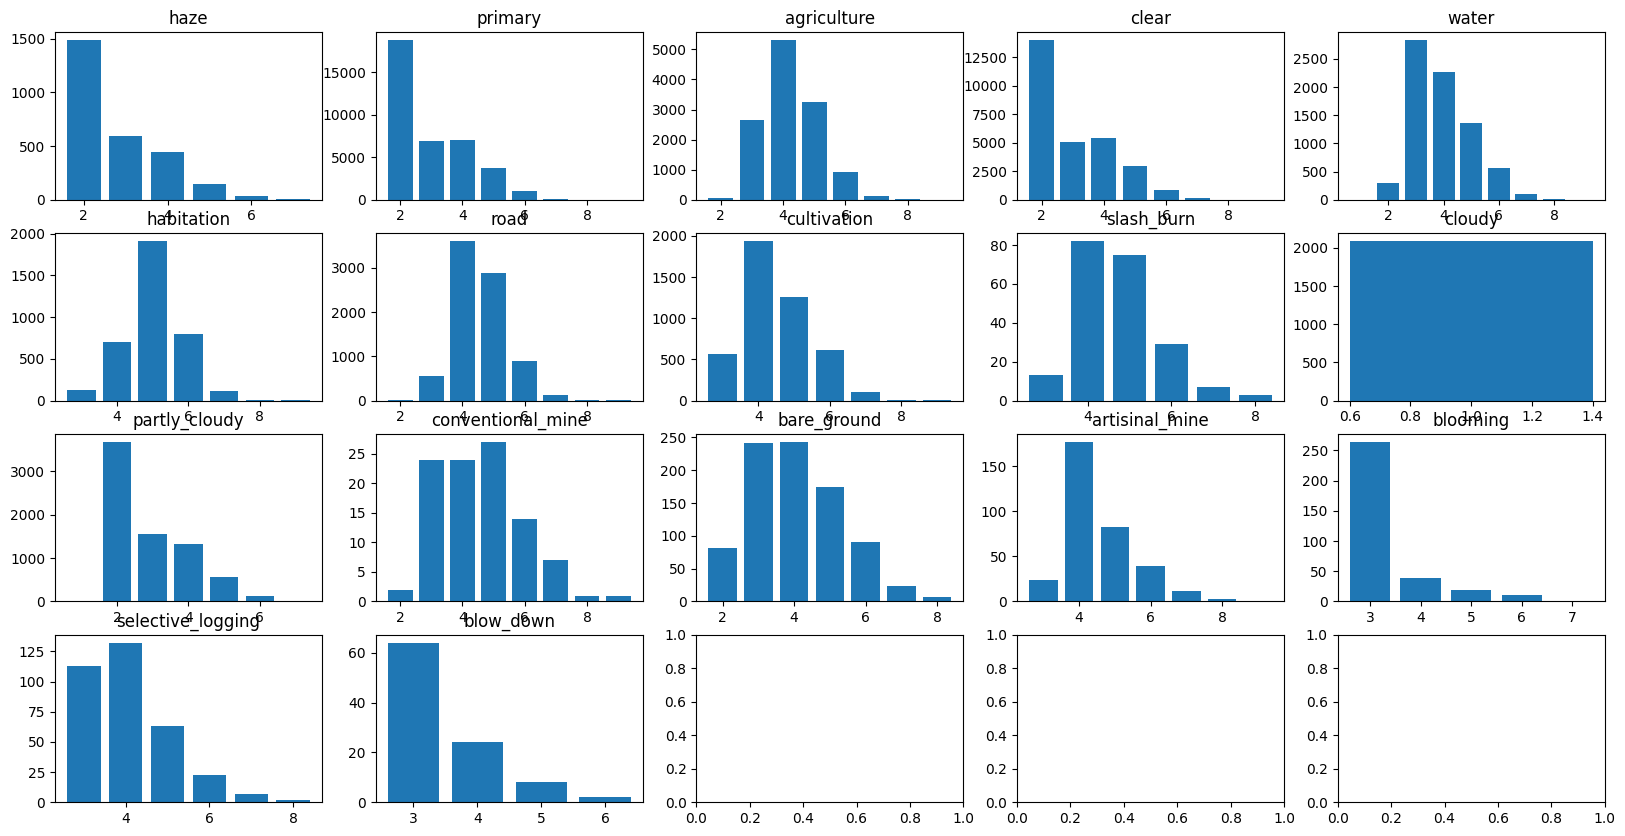

In [20]:
rows = 4
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,10))

l = 0
for row in range(rows):
    for col in range(cols):
        if len(label_list) == l:
            break
        else:
            current_label = label_list[l]
            cur_labels_counts = labels_df.loc[labels_df[current_label] == 1, :]['num_labels'].value_counts()
            axes[row, col].bar(cur_labels_counts.index.to_list(), cur_labels_counts.to_list());
            axes[row, col].set_title(current_label)
        l += 1
plt.show();

We can learn from the plots that:
- primary (forest) is a land cover/land use that is especially often dominating the whole chip
- chips containing tags: slash_burn and conventional_mine are characterized by the most diverse landscape 

Worth checking also seems to be which specific tags often cooccur:

In [21]:
def make_cooccurence_matrix(labels): # (Planet's code [6])
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix, cmap='coolwarm')
    return c_matrix

In [22]:
non_weather_list = [x for x in label_list if x not in ['clear', 'partly_cloudy', 'haze', 'cloudy']]

In [23]:
print(*non_weather_list, sep=", ")

primary, agriculture, water, habitation, road, cultivation, slash_burn, conventional_mine, bare_ground, artisinal_mine, blooming, selective_logging, blow_down


primary  agriculture  water  habitation  road  cultivation  \
primary              37513        11972   7001        3469  7728         4455   
agriculture          11972        12315   2712        2737  6034         3377   
water                 7001         2712   7411         915  2125          868   
habitation            3469         2737    915        3660  2786          895   
road                  7728         6034   2125        2786  8071         1294   
cultivation           4455         3377    868         895  1294         4477   
slash_burn             209          119     24          41    36          126   
conventional_mine       94           24     26          36    59            4   
bare_ground            683          225    206         163   323           89   
artisinal_mine         324           38    299          29   110           18   
blooming               332           32     16           4    10           35   
selective_logging      340           65     49          13   151           58   
blow_down               98           22      3           3     2            8   

                   slash_burn  conventional_mine  bare_ground  artisinal_mine  \
primary                   209                 94          683             324   
agriculture               119                 24          225              38   
water                      24                 26          206             299   
habitation                 41                 36          163              29   
road                       36                 59          323             110   
cultivation               126                  4           89              18   
slash_burn                209                  0           10               0   
conventional_mine           0                100           10               4   
bare_ground                10                 10          862              40   
artisinal_mine              0                  4           40             339   
blooming                    2                  0            3               0   
selective_logging           2                  0           13               6   
blow_down                   2                  0            4               0   

                   blooming  selective_logging  blow_down  
primary                 332                340         98  
agriculture              32                 65         22  
water                    16                 49          3  
habitation                4                 13          3  
road                     10                151          2  
cultivation              35                 58          8  
slash_burn                2                  2          2  
conventional_mine         0                  0          0  
bare_ground               3                 13          4  
artisinal_mine            0                  6          0  
blooming                332                  7          1  
selective_logging         7                340          1  
blow_down                 1                  1         98

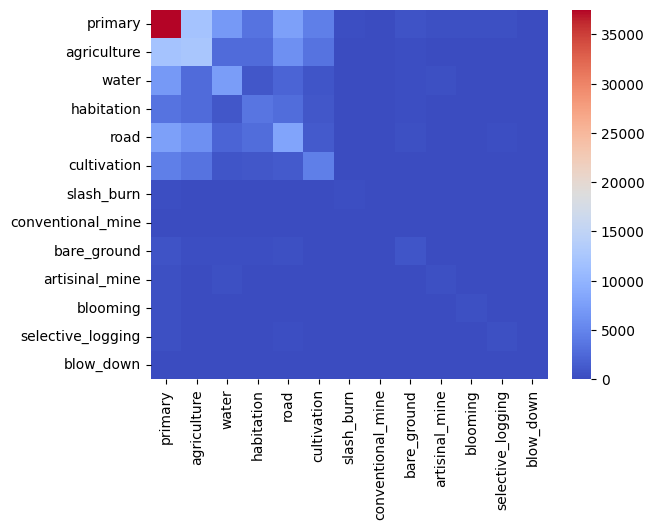

In [24]:
make_cooccurence_matrix(non_weather_list)

We can observe that:
- primary (forest) often cooccurs with agriculture, road, water and cultivation, similarly agriculture with road
- rare land cover/land use phenomena cooccur more often with primary (forest) than with other rare or common types

In [25]:
def prepare_tsne_2d(input_df:pd.DataFrame) -> pd.DataFrame:
    """Returns 2 t-SNE components as Pandas DataFrame."""
    # preparing data
    input_num_df = input_df.select_dtypes(include=['int', 'float'])
    input_num_na = input_num_df.dropna().to_numpy()
    
    # applying t-SNE 
    embedded_na = TSNE().fit_transform(input_num_na)
    
    # wrapping results into pd.DataFrame
    embedded_df = pd.DataFrame(embedded_na, columns=['tSNE_comp1', 'tSNE_comp2']) 
    return embedded_df

In [26]:
labels_tsne_df = prepare_tsne_2d(labels_df)

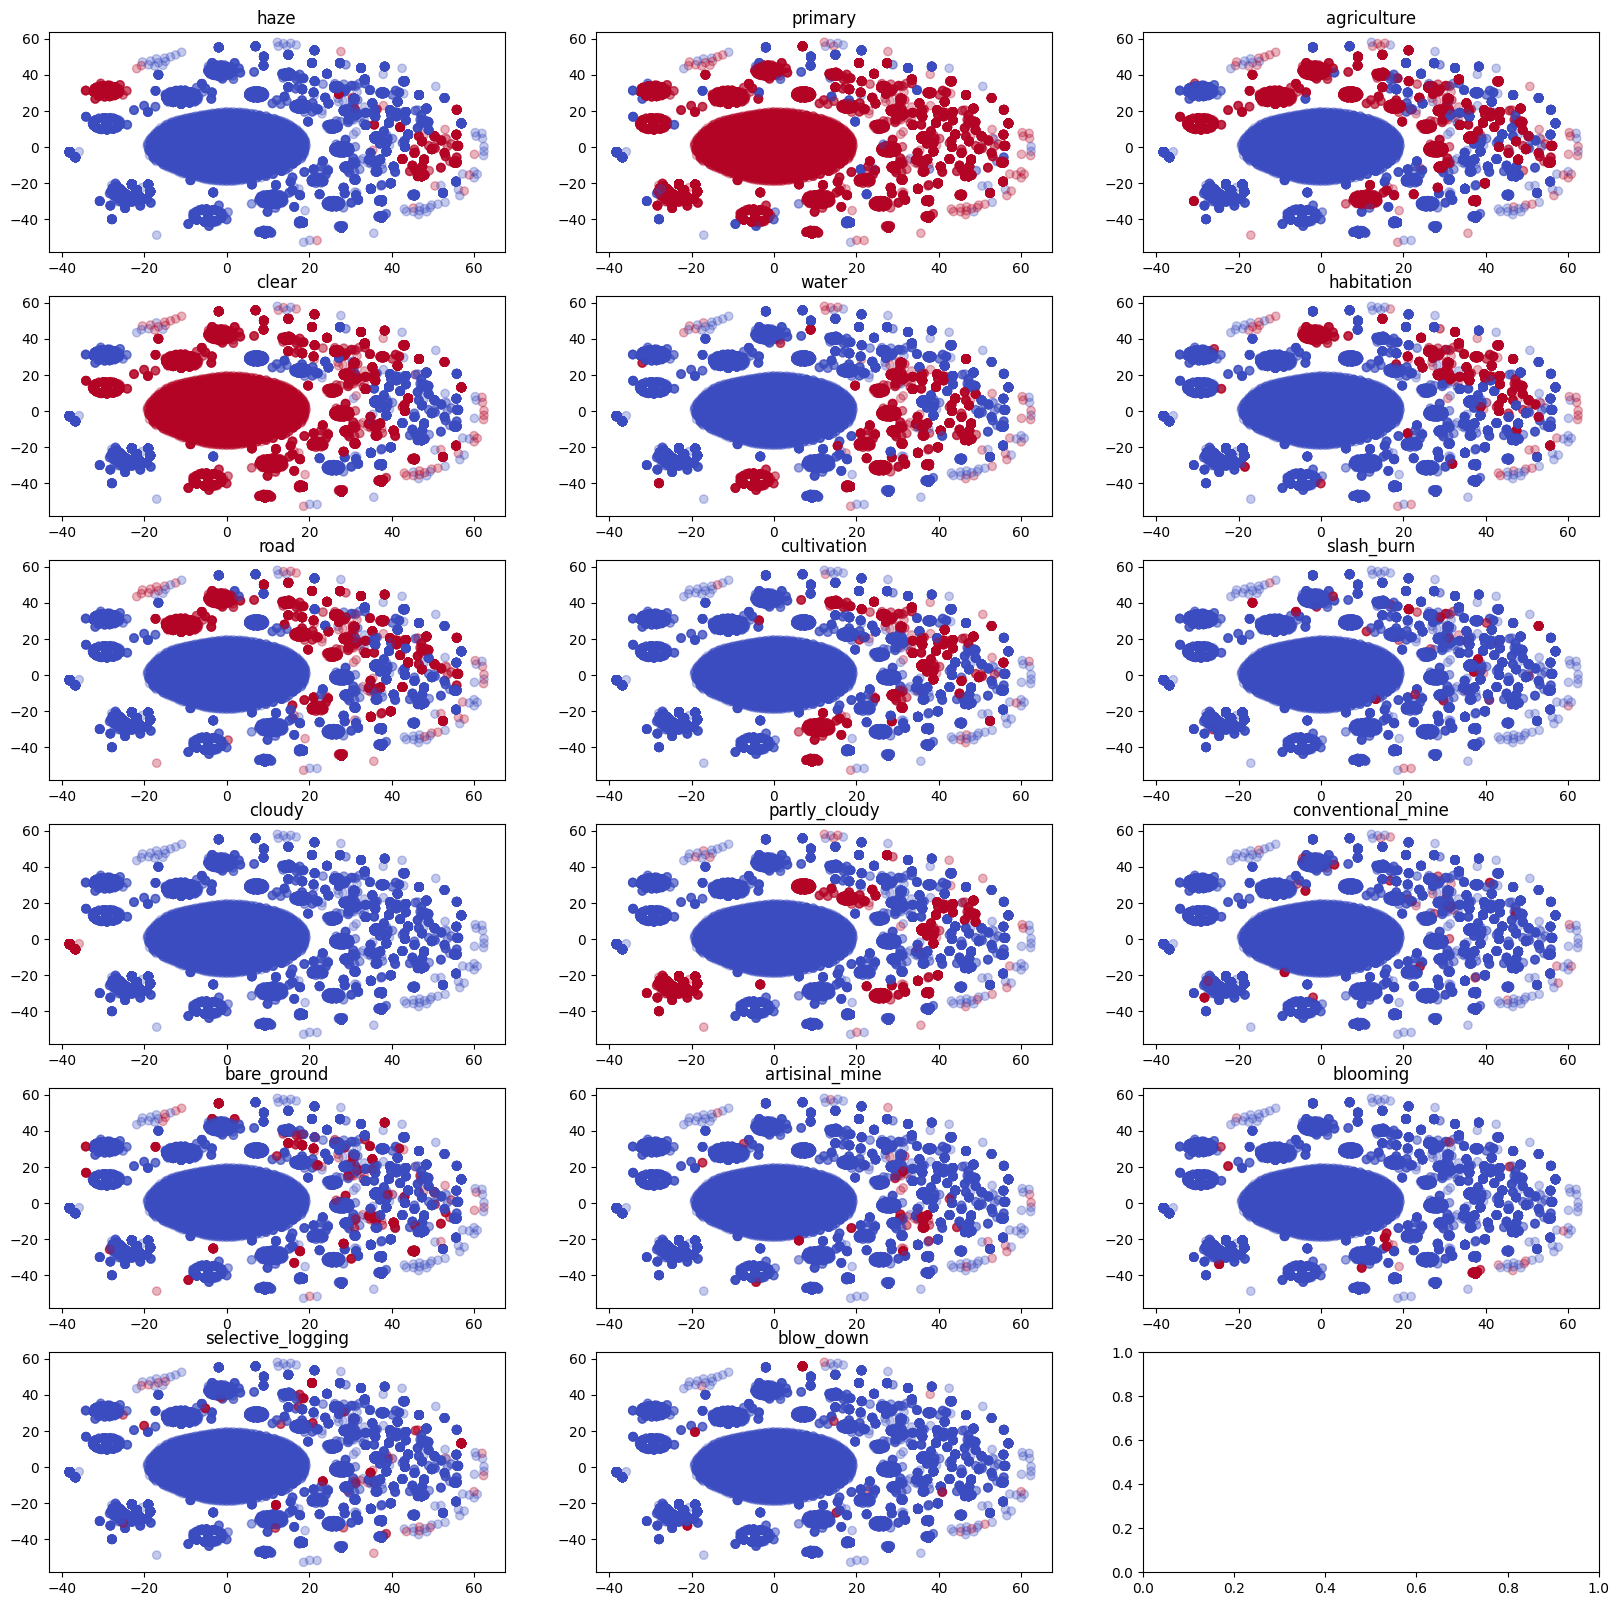

In [27]:
rows = 6
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(20,20))

l = 0
for row in range(rows):
    for col in range(cols):
        if len(label_list) == l:
            break
        else:
            current_label = label_list[l]
            merged_df = pd.concat([labels_tsne_df, labels_df[current_label]], axis=1)
            axes[row, col].scatter(x=merged_df['tSNE_comp1'], y=merged_df['tSNE_comp2'], c=merged_df[current_label], alpha=0.3, cmap='coolwarm')
            axes[row, col].set_title(current_label)
        l += 1
plt.show();

While the heatmap above was showing the number of two tags cooccurrences, it was not able to tell whether images form any kind of groupings in the feature space of all 17 tags (as opposed to having a random distribution of different set of tags). In order to reveal this, I computed t-SNE embeddings and plotted them 17 times, each coloured by another tag (red - tag present, blue - tag absent, for a specific image). The results show that:
- a huge number of images contain only two specific tags - '*primary*' and '*clear*'
- there are around 20 medium sized 'image types' - image groupings sharing a similar set of tags (e.g. a cluster directly underneath the largest cluster is mostly a combination of '*primary*', '*water*' and '*clear*' 
- the remainder of the images form smaller clusters or have more of a unique character 

### Step 3: Analyzing the training images

<b> Exploratory Data Analysis (EDA) combined with preprocessing </b>

At the beginning of exploring the training images, it is worth simply visualizing them. I will select a few that contain different sets of labels and plot them in a form of natural color composites:

In [91]:
example_images = []

In [92]:
criteria_labels = [['clear', 'agriculture'], ['clear', 'water'], ['clear', 'road'], ['clear', 'primary'], ['clear', 'habitation']]

In [93]:
for cl in criteria_labels:
    labels_temp_df = labels_df.loc[(labels_df[cl[0]]==1) & (labels_df[cl[1]]==1), ['image_name']].sample(n=1)
    example_images.append(labels_temp_df.values[0][0])

In [94]:
example_images

['train_36645', 'train_14703', 'train_32186', 'train_8984', 'train_19571']

In [95]:
example_labels = [labels_df.loc[labels_df['image_name']==example_images[i], ['tags']].values[0][0] for i in range(len(example_images))]
example_labels

['agriculture clear primary road',
 'agriculture clear habitation primary road water',
 'agriculture clear road water',
 'agriculture clear primary water',
 'clear habitation primary road water']

In [96]:
jpg_data_path = 'planets-dataset/planet/planet/train-jpg/'

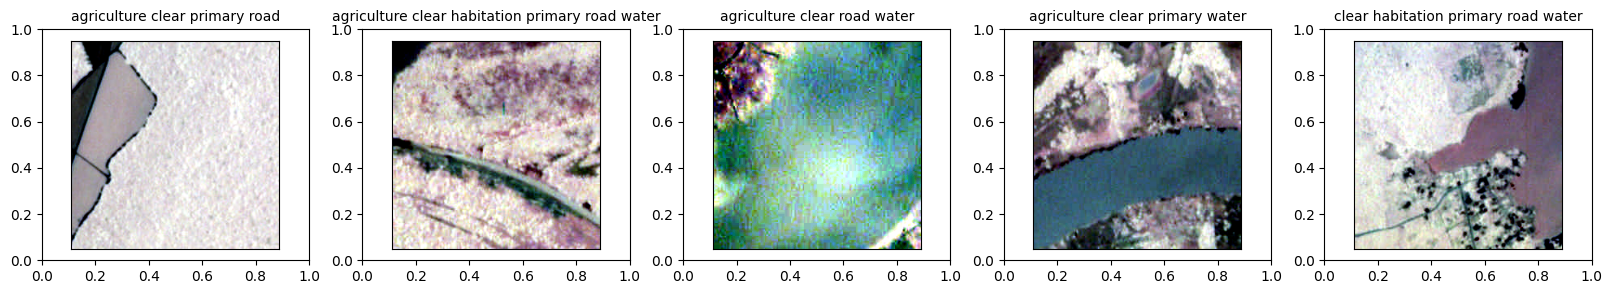

In [100]:
rows = 1
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,3))

l = 0
for col in range(cols):
    if len(example_images) == l:
        break
    else:
        current_label = example_labels[l]
        current_image_path = jpg_data_path + example_images[l] + '.jpg'
        current_image_na = np.array(Image.open(current_image_path))
        current_image_na = np.moveaxis(current_image_na, [2], [0])
        ep.plot_rgb(current_image_na, rgb=(0, 1, 2), ax=axes[col].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True)
        axes[col].set_title(current_label, fontsize=10)
    l += 1
plt.show();

The images seem to be correct except for the fact their values are flipped - areas that should be bright in a natural color composite image are dark. The opposite is also true. I will transform and plot them again: 

In [101]:
def flip_image_values(input_path:str, output_path:str, num_bits=8):
    """Flips image values and saves the output to disc."""
    
    max_value = 2**num_bits-1
    def complement_mapping(value): # func to calculate the flipped (complement) value element-wise
        return max_value - value
    complement_function = np.vectorize(complement_mapping)
    
    input_na = np.array(Image.open(input_path))
    complemented_na = complement_function(input_na).astype('uint8')
   
    complemented_img = Image.fromarray(complemented_na).convert('RGB')
    complemented_img.save(output_path)

In [102]:
images_to_flip = glob.glob(jpg_data_path + '*.jpg')

In [ ]:
for i in range(len(images_to_flip)):
    flip_image_values(images_to_flip[i], images_to_flip[i][:-4]+'_flipped.jpg')

I have tried two approaches to computing flipped images:
- simple for loop
- ThreadPool from multiprocessing package [7]

The first one turned out to be faster. It seems that distributing matrix cells over CPU cores (NumPy has this operation built-in for vectorized functions [8]) and analyzing each image after another is faster than distributing whole images between CPU cores using multiprocessing. 

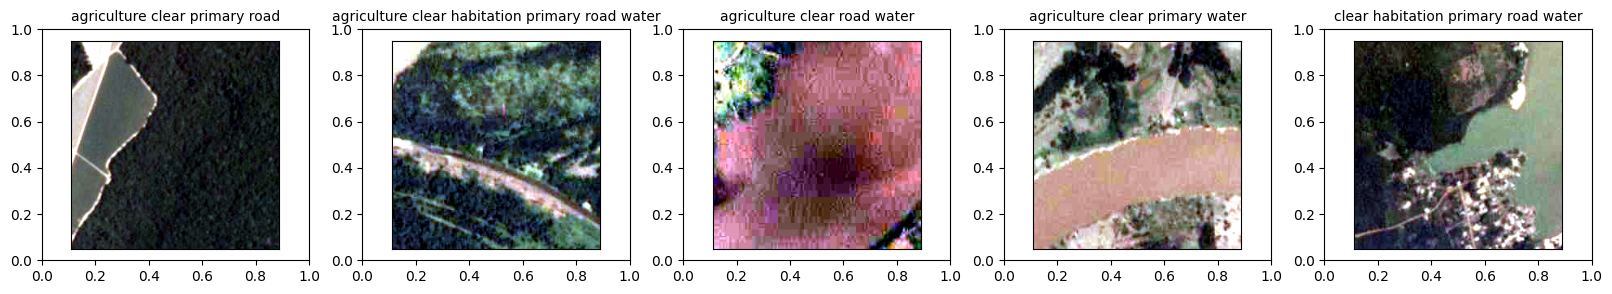

In [104]:
rows = 1
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,3))

l = 0
for col in range(cols):
    if len(example_images) == l:
        break
    else:
        current_label = example_labels[l]
        current_image_path = jpg_data_path + example_images[l] + '_flipped.jpg'
        current_image_na = np.array(Image.open(current_image_path))
        current_image_na = np.moveaxis(current_image_na, [2], [0])
        ep.plot_rgb(current_image_na, rgb=(0, 1, 2), ax=axes[col].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True, str_clip=2)
        axes[col].set_title(current_label, fontsize=10)
    l += 1
plt.show();

The images look much more realistic now. What is especially conspicuous is the diversity of water color. (Of course mapping could have been wrapped up as a function, but for exploration it is OK.) 

What would also be valuable is to view the histogram of each spectral band:

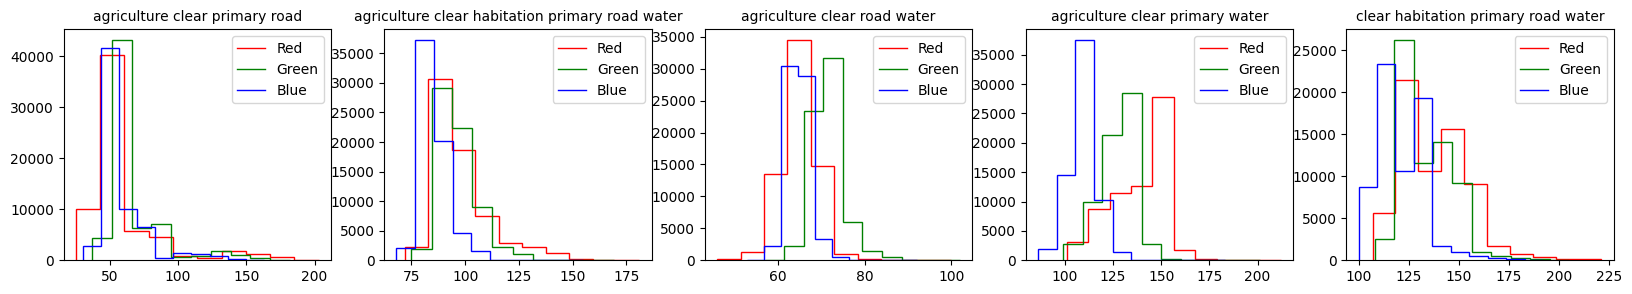

In [105]:
rgb_dict = {0: 'Red', 1: 'Green', 2: 'Blue'} 
rows = 1
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,3))

l = 0
for col in range(cols):
    if len(example_images) == l:
        break
    else:
        current_label = example_labels[l]
        current_image_path = jpg_data_path + example_images[l] + '_flipped.jpg'
        current_image_na = np.array(Image.open(current_image_path))
        for rgb in range(3):
            counts, bins = np.histogram(current_image_na[:, :, rgb])
            axes[col].stairs(counts, bins, label=rgb_dict[rgb], color=rgb_dict[rgb])
        axes[col].set_title(current_label, fontsize=10)
    l += 1
for ax in axes:
    ax.legend()
plt.show();

We can observe that:
- most pixel values are low or medium, indicating objects characterized by low reflectance values (e.g., forest).
- a lower number of pixels have high values, mostly representing roads and sands.

Satellite imagery always includes some noise. I am wondering if some denoising would help in making the labeling process more accurate. For this reason, I will create denoised versions of the original RGB images:

In [110]:
def denoise_RGB(input_path:str, output_path:str):
    """Computes inverse MNF transform for RGB image and saves output to disc."""
    # open image as Numpy Array
    input_na = np.array(Image.open(input_path))
    
    # MNF
    mnf = pysptools.noise.MNF()
    forward_na = mnf.apply(input_na)
    inverse_na = mnf.inverse_transform(forward_na)
    for band in [0,1,2]:
        inverse_na[:,:,band] = ((inverse_na[:,:,band] - inverse_na[:,:,band].min())/(inverse_na[:,:,band].max() - inverse_na[:,:,band].min()) * 255)
    inverse_na = inverse_na.astype('uint8')
    
    # save as .jpg
    inverse_img = Image.fromarray(inverse_na)
    inverse_img.save(output_path)

In [111]:
images_to_denoise = glob.glob(jpg_data_path + '*_flipped.jpg')

In [ ]:
for i in range(len(images_to_denoise)):
    denoise_RGB(images_to_denoise[i], images_to_denoise[i][:-4]+'_denoised.jpg')

To decide on the most efficient computation approach, I compared the time needed to process 10 images with 10 CPUs using:
- simple for loop 
- ThreadPool from multiprocessing package [7]
- dask (with 'auto' number of chunks) package [9] (applied only for values' scaling part)

Again the simple for loop was the fastest (5s), dask in the middle (17s), and ThreadPool the slowest (30s).

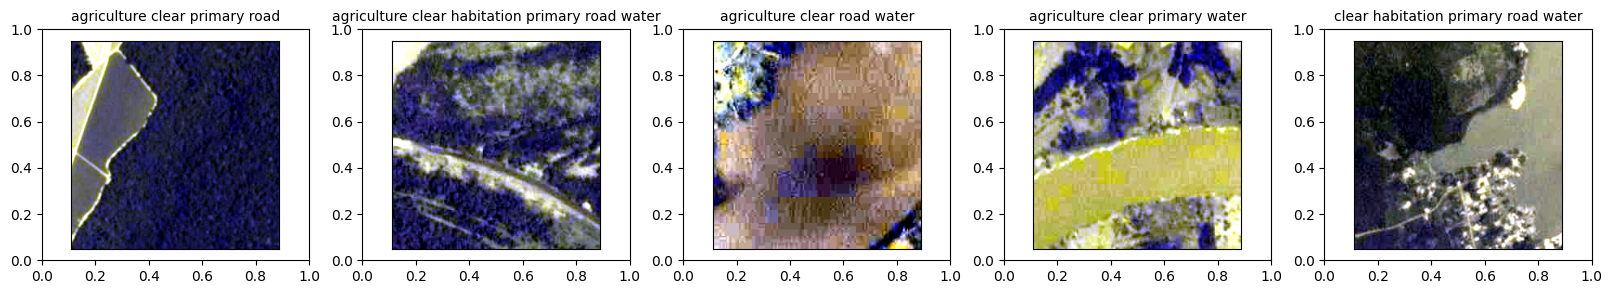

In [113]:
rows = 1
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,3))

l = 0
for col in range(cols):
    if len(example_images) == l:
        break
    else:
        current_label = example_labels[l]
        current_image_path = jpg_data_path + example_images[l] + '_flipped_denoised.jpg'
        current_image_na = np.array(Image.open(current_image_path))
        current_image_na = np.moveaxis(current_image_na, [2], [0])
        ep.plot_rgb(current_image_na, rgb=(0, 1, 2), ax=axes[col].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True, str_clip=2)
        axes[col].set_title(current_label, fontsize=10)
    l += 1
plt.show();

Finally, it would be valuable to check whether the data contain any potential outliers e.g images labeled incorrectly or unusual examples of correct classes. One way to do this is to calculate mean RGB values for *clear* images with only one land use/land cover, transform 3D data to 2D using t-SNE and plot the results. This approach allows to search for outliers in the spectral domain.

In [114]:
# filter all images with label clear and one other
pure_lulc_examples = []
pure_lulc_df = labels_df.loc[(labels_df['num_labels']==2) & (labels_df['clear']==1), ['image_name', 'tags']]

In [115]:
# tidy the 'tags' info
pure_lulc_df['pure_lulc'] = pure_lulc_df['tags'].apply(lambda x: [tag for tag in x.split(' ') if tag != 'clear'][0])
pure_lulc_df['lulc_color'] = pure_lulc_df['pure_lulc'].apply(lambda x: 'forestgreen' if x == 'primary' 
                                                             else 'dodgerblue' if x == 'water' 
                                                             else 'yellow' if x == 'agriculture' 
                                                             else 'red' if x == 'bare_ground'
                                                             else 'black')
pure_lulc_df = pure_lulc_df.drop('tags', axis=1)

In [116]:
# calculate mean RGB values
rgb_dict = {0: 'Red', 1: 'Green', 2: 'Blue'} 
for c in rgb_dict:
    pure_lulc_df['mean_'+rgb_dict[c]] = \
    pure_lulc_df['image_name'].apply(lambda x: np.mean(np.array(Image.open(os.path.join(jpg_data_path, x+'_flipped.jpg')))[:,:,c]) )

In [117]:
# view the resultant data
pure_lulc_df['pure_lulc'].unique(), pure_lulc_df.shape

(array(['primary', 'water', 'agriculture', 'bare_ground', 'road'],
       dtype=object),
 (14015, 6))

In [118]:
pure_lulc_df.head()

image_name pure_lulc   lulc_color   mean_Red  mean_Green  mean_Blue
2     train_2   primary  forestgreen  42.872757   58.185196  56.970581
3     train_3   primary  forestgreen  51.199265   65.322235  54.609268
13   train_13   primary  forestgreen  36.951477   53.231171  39.497086
15   train_15   primary  forestgreen  30.892868   45.682404  42.613220
16   train_16   primary  forestgreen  38.476044   53.719849  36.329666

In [119]:
# calcualte t-SNE values
pure_lulc_tsne_df = prepare_tsne_2d(pure_lulc_df)

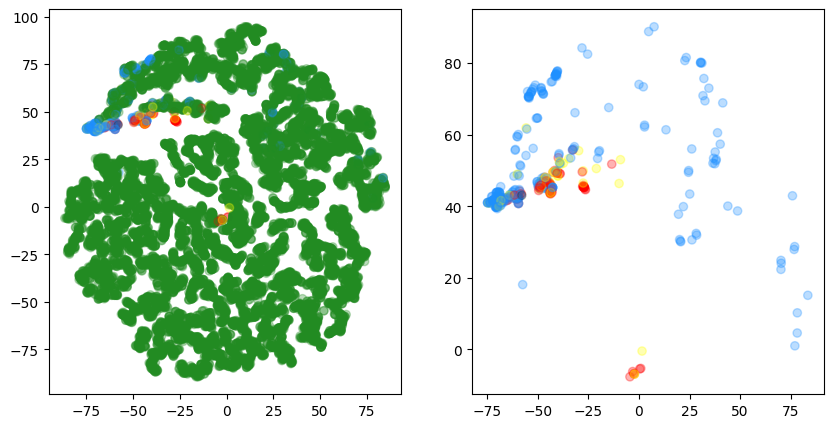

In [120]:
# concat and plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))

merged_df = pd.concat([pure_lulc_tsne_df.reset_index(drop=True), pure_lulc_df[['image_name', 'pure_lulc', 'lulc_color']].reset_index(drop=True)], axis=1)
non_primary_merged_df = merged_df.loc[merged_df['pure_lulc']!='primary',] 

axes[0].scatter(x=merged_df['tSNE_comp1'], y=merged_df['tSNE_comp2'], c=merged_df['lulc_color'], alpha=0.3)
axes[1].scatter(x=non_primary_merged_df['tSNE_comp1'], y=non_primary_merged_df['tSNE_comp2'], c=non_primary_merged_df['lulc_color'], alpha=0.3)

plt.show();

The results look very interesting. Three most important observations I made are:
1. Objects named as *water* are indeed very diverse spectrally, as seen previously
2. There is a part of the plot were *bare ground* overlaps with *agriculture* and this is quite natural
3. There is a cluster around tSNE_1 == 0 being a mix of *agriculture* and *bare ground* which is far away from the rest of points and therefore is worth exploring

In [121]:
group_df = non_primary_merged_df.query("tSNE_comp2 < 10 & lulc_color!='dodgerblue'")

In [123]:
group_df

tSNE_comp1  tSNE_comp2   image_name    pure_lulc lulc_color
687     -2.263394   -6.901440   train_2012  bare_ground        red
925      0.391965   -5.473143   train_2755  bare_ground        red
1380     0.899904   -5.328919   train_4040  bare_ground        red
2299    -2.333146   -6.889650   train_6668  agriculture     yellow
7096    -3.109915   -6.205595  train_20433  bare_ground        red
13214   -2.583730   -6.741712  train_38205  bare_ground        red
13482   -4.478523   -7.670003  train_39015  bare_ground        red
13637    1.516685   -0.476954  train_39476  agriculture     yellow
13756   -2.238278   -6.912138  train_39792  agriculture     yellow

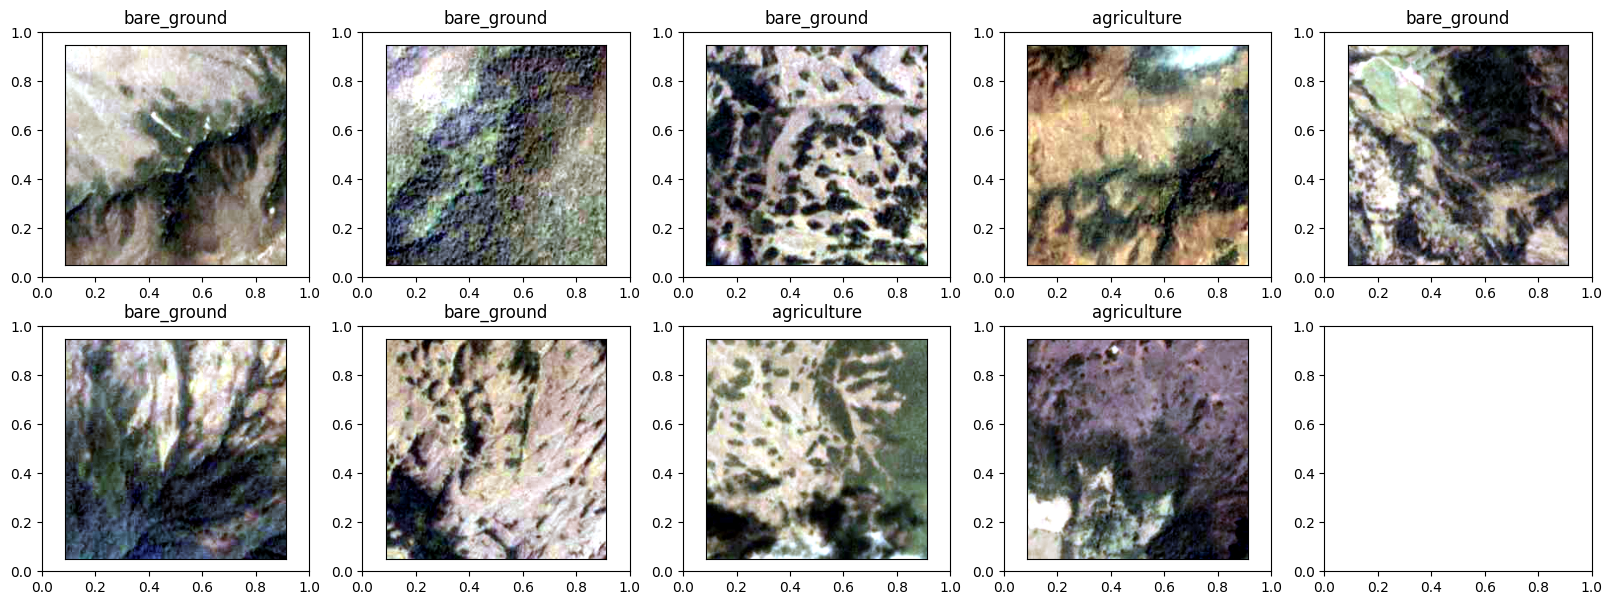

In [125]:
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,7))

l = 0
for row in range(rows):
    for col in range(cols):
        if group_df.shape[0] == l:
            break
        else:
            current_label = group_df.iloc[l, 3]
            current_image_na = np.array(Image.open(os.path.join(jpg_data_path, group_df.iloc[l, 2] + '_flipped.jpg')))
            current_image_na = np.moveaxis(current_image_na, [2], [0])
            ep.plot_rgb(current_image_na, rgb=(0, 1, 2), ax=axes[row, col].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True, str_clip=2)
            axes[row,col].set_title(current_label)
        l += 1
plt.show();

It seems that these are rocks partly overgrown by some pioneer vegetation. As the label set does not include any *low vegetation* class, these images lack the second label.

Similar analysis could potentially be also extended to include images with more than one LULC label e.g. by applying segmentation and comparing the characteristics of the obtained objects. Below I present the results of Segment Anything algorithm [10] applied to example images:

In [126]:
new_example_images = ['train_16192_flipped.jpg', 
                      'train_17875_flipped.jpg', 
                      'train_22562_flipped.jpg', 
                      'train_7498_flipped.jpg', 
                      'train_7575_flipped.jpg']
new_example_images.extend([img[:-4]+'_sam07.png' for img in new_example_images])

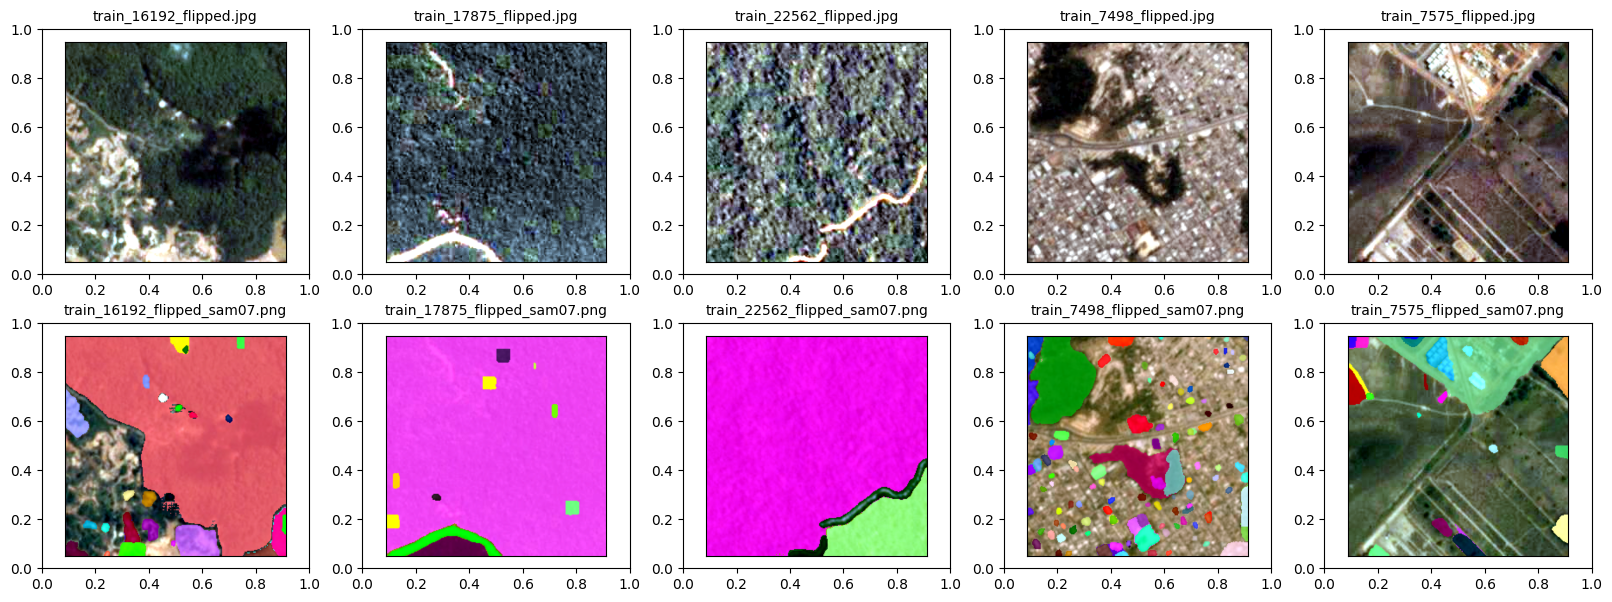

In [127]:
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20,7))

l = 0
for row in range(rows):
    for col in range(cols):
        if len(new_example_images) == l:
            break
        else:
            current_image_na = np.array(Image.open(new_example_images[l]))[:,:,:3]
            current_image_na = np.moveaxis(current_image_na, [2], [0])
            ep.plot_rgb(current_image_na, rgb=(0, 1, 2), ax=axes[row, col].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True, str_clip=2)
            axes[row,col].set_title(new_example_images[l], fontsize=10)
        l += 1
plt.show();

<b> Final ideas: </b>
1. The competition Authors mentioned [1] that roads may be confused with narrow rivers. This seems probable after looking at some of the examples. In order to address this challenge, additional data characterizing elevation could be used. DTM would probably be helpful. DSM synchronized temporally with the images may be difficult to find. 
2. Another remote sensing data types e.g. SAR would probably also be helpful in differentitaing LULC classes. Similar is true for additional optical data acquired on a different data e.g. in another growing season.